In [1]:
from yahoo_fin.stock_info import get_data
from datetime import date
import plotly.express as px
import pandas as pd
import numpy as np
from pathlib import Path
import csv
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import panel as pn
from panel.interact import interact
from MCForecastTools import MCSimulation
from scipy.optimize import Bounds, LinearConstraint, minimize

pn.extension("plotly")
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/lucasshaiman/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
portfolio_returns = pd.read_csv(r'data/portfolio_returns.csv').set_index('Date')
combined_portfolios = pd.read_csv(r'data/combined_portfolios.csv').set_index('Date')
combined_returns = pd.read_csv(r'data/combined_returns.csv').set_index('Date')
monte_carlo_df = combined_portfolios.dropna()
monte_carlo_dataframe = pd.read_csv(r'data/monte_carlo_dataframe.csv')
monte_carlo_dataframe = monte_carlo_dataframe.rename({'Unnamed: 0': 'Date'}, axis=1)
monte_carlo_dataframe = monte_carlo_dataframe.set_index('Date')
index_names = [
["BTC", "ETH", "SPY", "TLT", "GLD", "USD", "XLE", "XLF"],
["close", "close","close","close","close","close","close","close"]
# ["BTC", "ETH", "SPY", "TLT", "GLD", "USD"],
# ["close", "close","close","close","close","close"]
]
index_tuples = list(zip(*index_names))
new_index = pd.MultiIndex.from_tuples(index_tuples,names=["first", "second"])
monte_carlo_dataframe.columns = new_index

In [11]:
#Define frequently used functions.
# r is each stock's return, w is the portion of each stock in our portfolio, and covar is the covariance matrix
# Rate of return
def ret(r,w):
    return r.dot(w)


# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))


def sharpe (ret,vol):
    return ret/vol


def get_port_returns_graph():
    port_returns_fig = px.line(portfolio_returns)
    port_returns_fig.update_layout(
    title='Volatility',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
    )
    return port_returns_fig

def get_vol_graph():
    cumulative_returns = (1 + portfolio_returns).cumprod()
    volatility_fig = px.line(cumulative_returns)
    volatility_fig.update_layout(
        title='Volatility',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return volatility_fig

def get_vol_box():
    vol_box_fig = go.Figure()
    vol_box_fig.add_trace(go.Box(y=portfolio_returns['BTC'], name='Bitcoin',
                    marker_color = 'indianred', boxpoints=False))
    vol_box_fig.add_trace(go.Box(y=portfolio_returns['ETH'], name = 'Ethereum',
                    marker_color = 'lightseagreen', boxpoints=False))
    vol_box_fig.add_trace(go.Box(y=portfolio_returns['SPY'], name='S&P 500',
                    marker_color = 'blue', boxpoints=False))
    vol_box_fig.add_trace(go.Box(y=portfolio_returns['TLT'], name = 'Bonds (TLT)',
                    marker_color = 'grey', boxpoints=False))
    vol_box_fig.add_trace(go.Box(y=portfolio_returns['USD'], name = 'US Dollar',
                    marker_color = 'green', boxpoints=False))
    vol_box_fig.add_trace(go.Box(y=portfolio_returns['GLD'], name='Gold',
                    marker_color = 'gold', boxpoints=False))
    vol_box_fig.add_trace(go.Box(y=portfolio_returns['XLE'], name = 'Energy (XLE)',
                    marker_color = 'red', boxpoints=False))
    vol_box_fig.add_trace(go.Box(y=portfolio_returns['XLF'], name = 'Financials (XLF)',
                    marker_color = 'black', boxpoints=False))

    vol_box_fig.update_layout(
        title='Daily Return Distributions',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=False
    )

    return vol_box_fig

def get_rolling():
    # Calculate the rolling standard deviation for all portfolios using a 21-day window
    roll = portfolio_returns.rolling(window=120).std()
    # Plot the rolling standard deviation
    roll_120_fig = px.line(roll)
    roll_120_fig.update_layout(
        title='Rolling Returns',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return roll_120_fig

def get_ewm():
    ewm_calc = portfolio_returns.ewm(halflife=120).std()
    roll_120_line_fig = px.line(ewm_calc)
    roll_120_line_fig.update_layout(
        title='Rolling Returns',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return roll_120_line_fig

def get_sharpe_ratios():
    sharpe_ratios = (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252))
    sharpe_bar_fig = px.bar(sharpe_ratios,labels=dict(x="Assets", y="Sharpe Ratio", color="Sharpe Ratio"),color = sharpe_ratios, color_continuous_scale='Bluered_r')
    sharpe_bar_fig.update_layout(
    title='Sharpe Ratios',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
    )
    return sharpe_bar_fig

def get_correlation():
    price_correlation_new = portfolio_returns.corr()
    heatmap_fig = px.imshow(price_correlation_new, color_continuous_scale='Bluered_r', labels = dict(color='Corerelation'))
    heatmap_fig.update_layout(
        title='Individual Asset Correlations',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return heatmap_fig

def get_cumulative_portfolios():
    cum_returns = px.line(combined_portfolios)
    cum_returns.update_layout(
        title='5 Year Cumulative Portfolio Returns',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return cum_returns

def get_portfolio_sharpe_ratios():
    portfolio_sharpe_ratios = (combined_returns.mean() * 252) / (combined_returns.std() * np.sqrt(252))
    portfolio_sharpe_fig = px.bar(portfolio_sharpe_ratios,labels=dict(x="Assets", y="Sharpe Ratio", color="Sharpe Ratio"),color = portfolio_sharpe_ratios, color_continuous_scale='Bluered_r')
    portfolio_sharpe_fig.update_layout(
        title='Portoflio Sharpe Ratios',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return portfolio_sharpe_fig

def get_traditional_mc():
    mc_traditional = MCSimulation(
    monte_carlo_dataframe,
    weights = [0,0,0.50,0.40,0.05,0.05,0,0],
    num_simulation = 200,
    num_trading_days = 252*5)
    mc_trad_px = mc_traditional.calc_cumulative_return()
    mc_trad_fig = px.line(mc_trad_px)
    mc_trad_fig.update_layout(
        title='Traditional Portfolio Monte Carlo Simulation',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return mc_trad_fig
    
def get_btc_mc():
    mc_btc_port = MCSimulation(
    monte_carlo_dataframe,
    weights = [0.10,0,0.50,0.40,0,0,0,0],
    num_simulation = 200,
    num_trading_days = 252*5)
    mc_btc_px = mc_btc_port.calc_cumulative_return()
    mc_btc_fig = px.line(mc_btc_px)
    mc_btc_fig.update_layout(
        title='Bitcoin Portfolio Monte Carlo Simulation',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return mc_btc_fig
    
    
def get_eth_mc():
    mc_eth_port = MCSimulation(
    monte_carlo_dataframe,
    weights = [0,0.10,0.50,0.40,0,0,0,0],
    num_simulation = 200,
    num_trading_days = 252*5)
    mc_eth_px = mc_eth_port.calc_cumulative_return()
    mc_eth_fig = px.line(mc_eth_px)
    mc_eth_fig.update_layout(
        title='Ethereum Portfolio Monte Carlo Simulation',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return mc_eth_fig

    
def get_alpha_mc():
    mc_alpha_portfolio = MCSimulation(
    monte_carlo_dataframe,
    weights = [0.07,0.08,0.27,0.2,0.24,0.15,0,0],
    num_simulation = 200,
    num_trading_days = 252*5)
    mc_alpha_px = mc_alpha_portfolio.calc_cumulative_return()
    mc_alpha_fig = px.line(mc_alpha_px)
    mc_alpha_fig.update_layout(
        title='Alpha Portfolio Monte Carlo Simulation',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return mc_alpha_fig
    
    
def get_port_sharpes():
    portfolio_sharpe_ratios = (combined_returns.mean() * 252) / (combined_returns.std() * np.sqrt(252))
    portfolio_sharpe_fig = px.bar(portfolio_sharpe_ratios,labels=dict(x="Assets", y="Sharpe Ratio", color="Sharpe Ratio"),color = portfolio_sharpe_ratios, color_continuous_scale='Bluered_r')
    portfolio_sharpe_fig.update_layout(
        title='Portoflio Sharpe Ratios',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=True
    )
    return portfolio_sharpe_fig
    
    
def get_histogram():
    histogram_fig = px.histogram(portfolio_returns)
    histogram_fig.update_layout(
    title='Histogram Showing Standard Deviation of Assets',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True,
    barmode = 'stack'
    )
    return histogram_fig
    
    
def get_all_histograms():
    all_histo_fig = make_subplots(rows=4, cols=2)
    trace0 = go.Histogram(x=portfolio_returns['BTC'],name='BTC')
    trace1 = go.Histogram(x=portfolio_returns['ETH'],name='ETH')
    trace2 = go.Histogram(x=portfolio_returns['SPY'],name='SPY')
    trace3 = go.Histogram(x=portfolio_returns['TLT'],name='TLT')
    trace4 = go.Histogram(x=portfolio_returns['GLD'],name='GLD')
    trace5 = go.Histogram(x=portfolio_returns['TLT'],name='TLT')
    trace6 = go.Histogram(x=portfolio_returns['XLE'],name='XLE')
    trace7 = go.Histogram(x=portfolio_returns['XLF'],name='XLF')
    all_histo_fig.append_trace(trace0, 1, 1)
    all_histo_fig.append_trace(trace1, 1, 2)
    all_histo_fig.append_trace(trace2, 2, 1)
    all_histo_fig.append_trace(trace3, 2, 2)
    all_histo_fig.append_trace(trace4, 3, 1)
    all_histo_fig.append_trace(trace5, 3, 2)
    all_histo_fig.append_trace(trace6, 4, 1)
    all_histo_fig.append_trace(trace7, 4, 2)
    all_histo_fig.update_layout(
    title='Histogram Showing Standard Deviation of Assets',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True)

    return all_histo_fig

def get_frontier():
    df2 = portfolio_returns.copy()
    df2.drop('XLE', axis=1, inplace=True)
    df2.drop('XLF', axis=1, inplace=True)
    df=portfolio_returns.copy()
    df.drop('XLE', axis=1, inplace=True)
    df.drop('XLF', axis=1, inplace=True)

    # Calculate annualized average return for each stock. Annualized average return = Daily average return * 252 business days.
    r = np.mean(df,axis=0)*252

    # Create a covariance matrix
    covar = df.cov()
    bounds = Bounds(0, 1)
    linear_constraint = LinearConstraint(np.ones((df2.shape[1],), dtype=int),1,1)
    #Create x0, the first guess at the values of each stock's weight.
    weights = np.ones(df2.shape[1])
    x0 = weights/np.sum(weights)
    #Define a function to calculate volatility
    fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

    #These are the weights of the stocks in the portfolio with the lowest level of risk possible.
    w_min = res.x

    np.set_printoptions(suppress = True, precision=2)
    #Define 1/Sharpe_ratio
    fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
    res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

    #These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
    w_sharpe = res_sharpe.x
    w = w_min
    num_ports = 100
    gap = (np.amax(r) - ret(r,w_min))/num_ports
    
    
    all_weights = np.zeros((num_ports, len(df.columns)))
    all_weights[0],all_weights[1]=w_min,w_sharpe
    ret_arr = np.zeros(num_ports)
    ret_arr[0],ret_arr[1]=ret(r,w_min),ret(r,w_sharpe)
    vol_arr = np.zeros(num_ports)
    vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)
    
    for i in range(num_ports):
        port_ret = ret(r,w) + i*gap
        double_constraint = LinearConstraint([np.ones(df2.shape[1]),r],[1,port_ret],[1,port_ret])

        #Create x0: initial guesses for weights.
        x0 = w_min
        #Define a function for portfolio volatility.
        fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
        a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)

        all_weights[i,:]=a.x
        ret_arr[i]=port_ret
        vol_arr[i]=vol(a.x,covar)

    sharpe_arr = ret_arr/vol_arr  
    
    fig = px.scatter(x=vol_arr, y=ret_arr, color=sharpe_arr)
    fig.update_layout(
    title='Efficient Frontier',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title="Volatility",
    yaxis_title="Return"
    )
    return fig

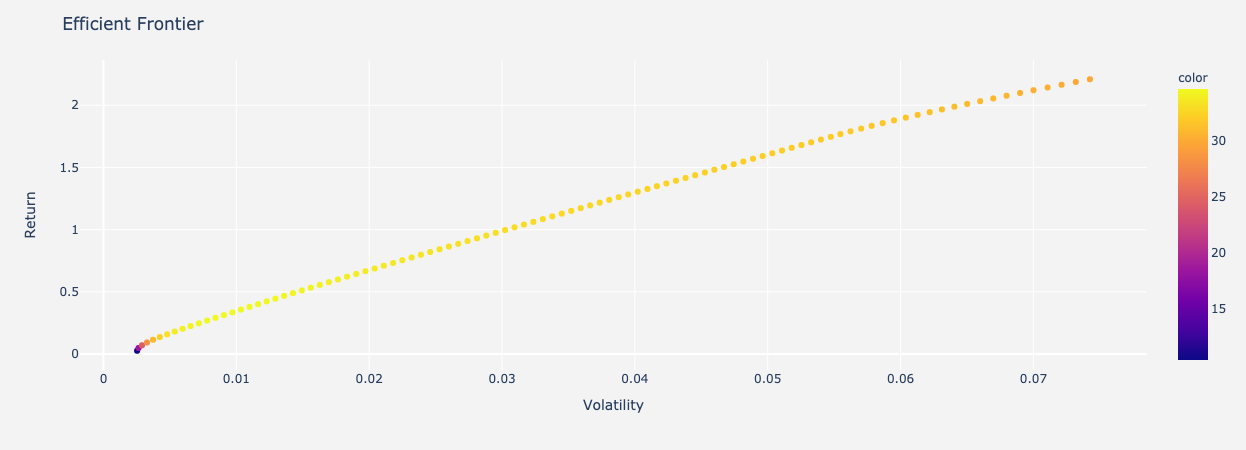

In [12]:
get_frontier()

In [13]:
overview_row = pn.Row(get_cumulative_portfolios(),get_port_sharpes())

In [14]:
trad_row = pn.Row(
        pn.Row('# Traditional Portfolio'),
        get_traditional_mc(),
        '##There is a 95% chance that an initial investment of $1000 in the portfolio over the next 5 years will end within in the range of $1046.48 and $2876.67')

btc_row = pn.Row(
    pn.Row('# Bitcoin Portfolio'),
    get_btc_mc(),
    '## There is a 95% chance that an initial investment of $1000 in the portfolio over the next 5 years will end within in the range of $1686.03 and $5516.51')

eth_row = pn.Row('# Ethereum Portfolio',
    pn.Row(get_eth_mc(),
    '## There is a 95% chance that an initial investment of $1000 in the portfolio over the next 5 years will end within in the range of $2656.66 and $10589.95'))

alpha_row = pn.Row(
    pn.Row('# Alpha Portfolio'),
    pn.Row(get_alpha_mc(),
    '## There is a 95% chance that an initial investment of $1000 in the portfolio over the next 5 years will end within in the range of $2970.51 and $9815.35'))

overview_column = pn.Column(
    '# How Does Each Portfolio Stack Up?',
    pn.Row(get_cumulative_portfolios(),
    get_port_sharpes())
)

mc_column = pn.Column(
   pn.Row(trad_row,btc_row),pn.Row(eth_row,alpha_row)
)

ef_column = pn.Column('Efficient Frontier',
                     get_frontier())

vol_column = pn.Column(
    pn.Row('# At a Glance - Volatility of Assets',
    get_vol_box()), 
    pn.Row(get_vol_graph(),
    get_port_returns_graph())
)


roll_column = pn.Column(
    pn.Row('# At a Glance - Rolling 21 Day Average of Assets'),
    pn.Row(get_rolling(),
    get_ewm())
)


sharpe_column = pn.Column(
    pn.Row('# At a Glance - Sharpe Ratios of Each Asset'),
    pn.Row(get_all_histograms(),
    get_sharpe_ratios())
)


heat_column = pn.Column(
    '# Heatmap Correlations Related to Each Asset',
    get_correlation()
)


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simula

In [15]:
tabs = pn.Tabs(
    ("Volatility",vol_column),
    ("Rolling Averages",roll_column),
    ("Sharpe Ratios",sharpe_column),
    ("Heatmap",heat_column),
    ("Effecient Frontier",ef_column),
    ("Monte Carlo", mc_column),
    ("Conclusion", overview_column),
)

In [16]:
tabs.show()

Launching server at http://localhost:61162
